<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#functions" data-toc-modified-id="functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>functions</a></span><ul class="toc-item"><li><span><a href="#image" data-toc-modified-id="image-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>image</a></span></li><li><span><a href="#metrics" data-toc-modified-id="metrics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>metrics</a></span></li><li><span><a href="#align" data-toc-modified-id="align-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>align</a></span></li></ul></li><li><span><a href="#process-image" data-toc-modified-id="process-image-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>process image</a></span></li><li><span><a href="#all-images-(small)" data-toc-modified-id="all-images-(small)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>all images (small)</a></span></li><li><span><a href="#pyramid" data-toc-modified-id="pyramid-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>pyramid</a></span></li></ul></div>

# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import os
from sklearn.metrics import mean_squared_error

In [2]:
def show_image(image):
    mu = min(10 / image.shape[0], 10. / image.shape[1])
    plt.figure(figsize=(mu * image.shape[1], mu * image.shape[0]))
    plt.imshow(image)
    plt.show()

# data

In [3]:
from skimage import io

In [4]:
images = []
data_dir = '../data/01-channel-align-pub/small/'
for fn in os.listdir(data_dir):
    images.append(io.imread(data_dir + fn))

In [5]:
big_images = []
data_dir = '../data/01-channel-align-pub/big/'
for fn in os.listdir(data_dir):
    big_images.append(io.imread(data_dir + fn))

In [6]:
image = images[-1]

# functions

## image

In [58]:
def show_channels(red=None, green=None, blue=None):
    def _fill_zeros(red, green, blue):
        if red is None:
            if green is None:
                red = np.zeros_like(blue)
            else:
                red = np.zeros_like(green)
        return red
    red = _fill_zeros(red, green, blue)
    green = _fill_zeros(green, blue, red)
    blue = _fill_zeros(blue, red, green)
    show_image(np.array((red, green, blue)).transpose((1, 2, 0)))

In [59]:
def split_channels(image):
    length = image.shape[0] // 3
    return image[2 * length: 3 * length], image[length: 2 * length], image[:length]

In [79]:
def strip_frame(image):
    fr_len, fr_wi = int(0.05 * image.shape[0]), int(0.05 * image.shape[1])
    return image[fr_len: -fr_len, fr_wi:-fr_wi]

In [80]:
def preprocess_image(image):
#     stripped_image = strip_frame(image)
    red, green, blue = split_channels(image)
    red, green, blue = strip_frame(red), strip_frame(green), strip_frame(blue)
    return red, green, blue

## metrics

In [81]:
def mse(im1, im2):
    return ((im1.astype(float) - im2.astype(float)) ** 2).sum() / np.prod(im1.shape)

In [82]:
def cross_corr(im1, im2):
    im1 = im1.astype(float)
    im2 = im2.astype(float)
    return np.multiply(im1, im2).sum() / np.sqrt(np.multiply(im1, im1).sum()) / np.sqrt(np.multiply(im2, im2).sum())

## align

In [138]:
def _get_bbox_slice(ul, br):
    return slice(ul[0], br[0]), slice(ul[1], br[1])


def _intersect(ul1, br1, ul2, br2):
    ul = (max(ul1[0], ul2[0]), max(ul1[1], ul2[1]))
    br = (min(br1[0], br2[0]), min(br1[1], br2[1]))
    return ul, br


def _locate_on_canvas(ch, ul, offset):
    canvas = np.zeros(
        (ch.shape[0] + 2 * offset, ch.shape[1] + 2 * offset), dtype=np.uint8)
    br = (ul[0] + ch.shape[0], ul[1] + ch.shape[1])
    canvas[_get_bbox_slice(ul, br)] = ch
    return br, canvas


def _get_bbox(im, ul, br):
    return im[_get_bbox_slice(ul, br)]


def align2(ch1, ch2, offset=20):

    best_x, best_y, best_metric = 0, 0, np.nan
    for x in range(0, 2 * offset + 1):
        for y in range(0, 2 * offset + 1):
            ul1 = (x, y)
            ul2 = (offset, offset)
            br1, can1 = _locate_on_canvas(ch1, ul1, offset)
            br2, can2 = _locate_on_canvas(ch2, ul2, offset)

            ul, br = _intersect(ul1, br1, ul2, br2)

            ch1i = _get_bbox(can1, ul, br)
            ch2i = _get_bbox(can2, ul, br)

            #             show_image(np.array([ch1i, ch2i, np.zeros(ch1i.shape)]).transpose((1, 2, 0)))

            metric = cross_corr(ch1i, ch2i)
            if np.nanmax((best_metric, metric)) == metric:
                best_x, best_y, best_metric = x, y, metric
                c1, c2 = ch1i, ch2i


#     print('-' * 80)
#     print(best_x, best_y, best_metric)
#     show_channels(c1, c2)
    return best_x, best_y

In [140]:
def align_all(red, green, blue, offset=20, strip_frame=True):

    ro_ul = align2(red, blue, offset)
    ro_br, r_can = _locate_on_canvas(red, ro_ul, offset)

    go_ul = align2(green, blue, offset)
    go_br, g_can = _locate_on_canvas(green, go_ul, offset)

    bo_ul = (offset, offset)
    bo_br, b_can = _locate_on_canvas(blue, bo_ul, offset)
    
    if strip_frame:
        ul1, br1 = _intersect(ro_ul, ro_br, go_ul, go_br)
        ul, br = _intersect(ul1, br1, bo_ul, bo_br)
        
        r_can = _get_bbox(r_can, ul, br)
        g_can = _get_bbox(g_can, ul, br)
        b_can = _get_bbox(b_can, ul, br)
        
        return {'ul': ul, T}
    
    print(ro_ul, go_ul, bo_ul)

    show_channels(r_can.astype(red.dtype), g_can.astype(red.dtype), b_can.astype(red.dtype))
    
    return (r_can, g_can, b_can)

# process image

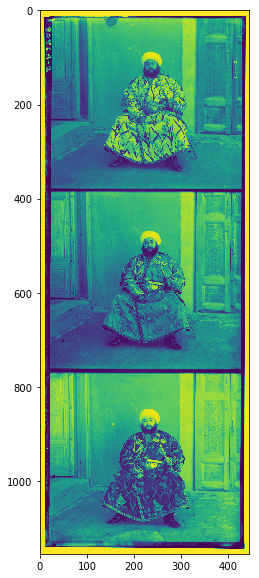

In [141]:
show_image(image)

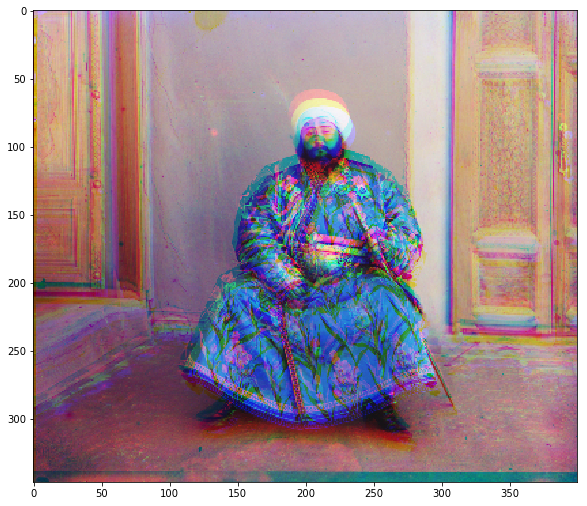

In [142]:
prep_image = preprocess_image(image)
show_channels(*prep_image)

(23, 20) (21, 18) (15, 15)


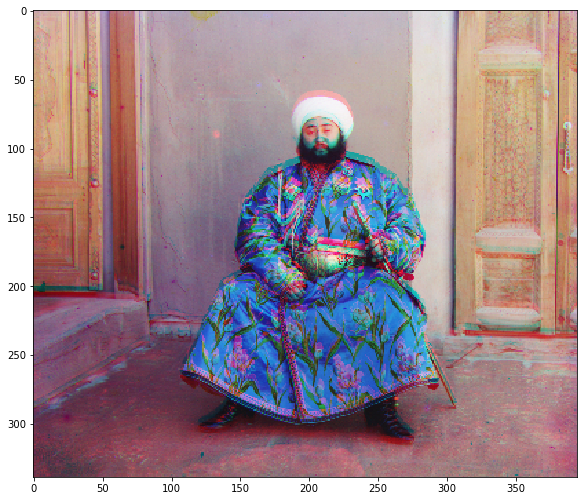

(array([[204, 202, 194, ..., 211, 212, 202],
        [209, 203, 199, ..., 219, 200, 213],
        [204, 204, 204, ..., 215, 201, 204],
        ...,
        [101, 111, 113, ..., 150, 160, 154],
        [110, 107, 120, ..., 164, 161, 155],
        [ 93, 120, 119, ..., 163, 169, 147]], dtype=uint8),
 array([[160, 173, 174, ..., 184, 179, 135],
        [158, 166, 165, ..., 190, 163, 160],
        [170, 169, 168, ..., 183, 170, 124],
        ...,
        [ 47,  48,  60, ..., 110,  98,  93],
        [ 47,  49,  52, ..., 115, 101, 101],
        [ 57,  52,  51, ..., 105, 104,  98]], dtype=uint8),
 array([[177, 175, 178, ..., 180, 187, 196],
        [168, 175, 173, ..., 184, 190, 184],
        [167, 159, 164, ..., 173, 184, 183],
        ...,
        [ 74,  77,  76, ..., 124, 126, 119],
        [ 73,  75,  71, ..., 125, 124, 123],
        [ 74,  65,  68, ..., 121, 127, 119]], dtype=uint8))

In [143]:
align_all(*prep_image, offset=15)

# all images (small)

Aligned
(30, 21) (23, 20) (20, 20)


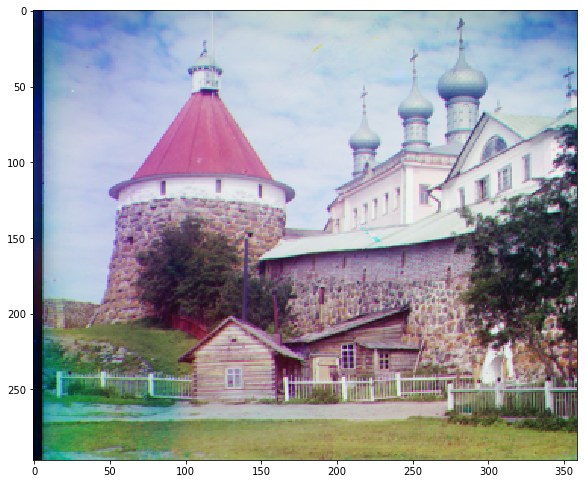

Aligned
(29, 24) (25, 21) (20, 20)


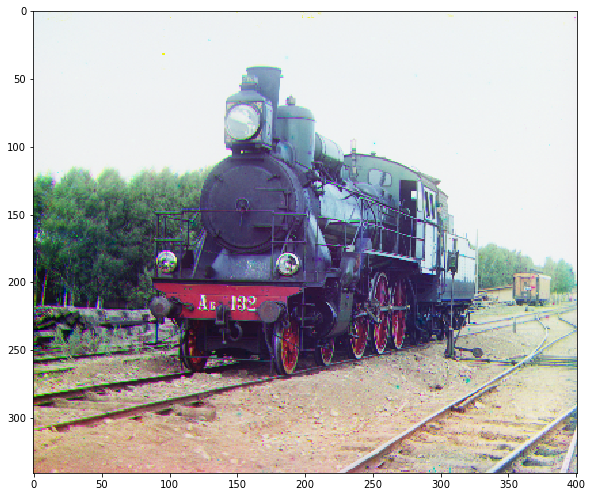

Aligned
(21, 22) (18, 21) (20, 20)


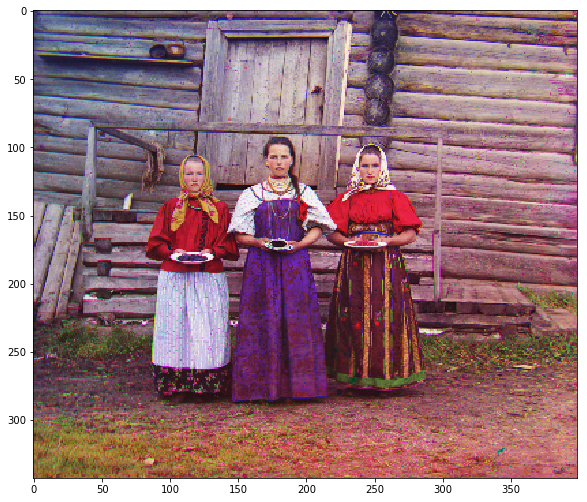

Aligned
(28, 24) (23, 22) (20, 20)


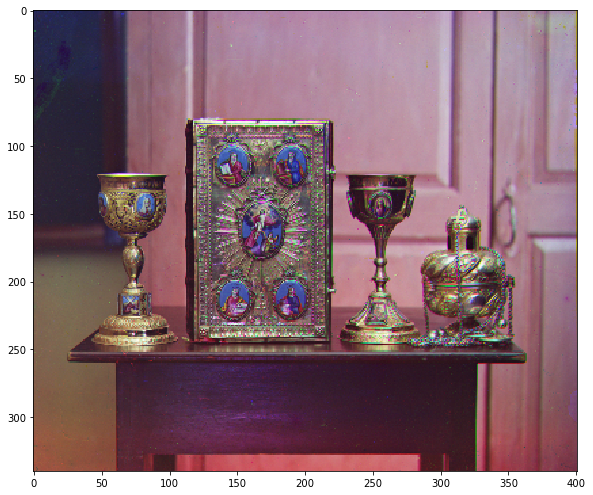

Aligned
(32, 25) (25, 23) (20, 20)


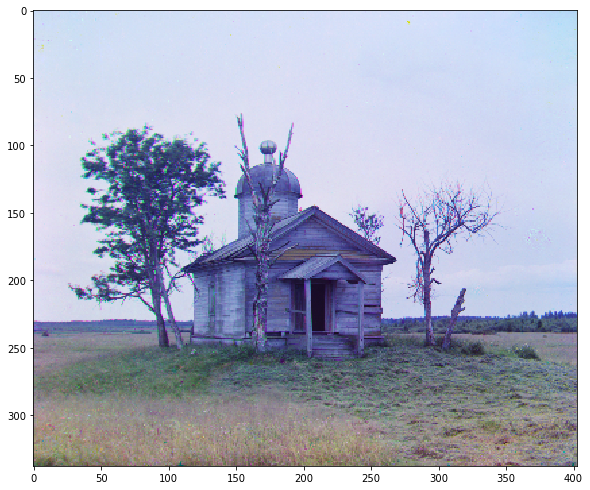

Aligned
(37, 28) (28, 25) (20, 20)


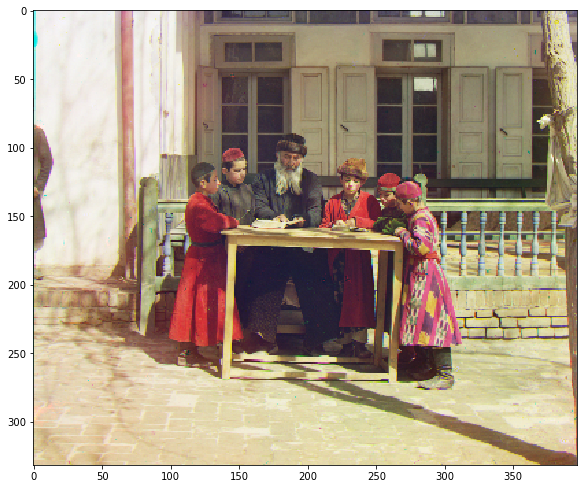

Aligned
(28, 25) (26, 23) (20, 20)


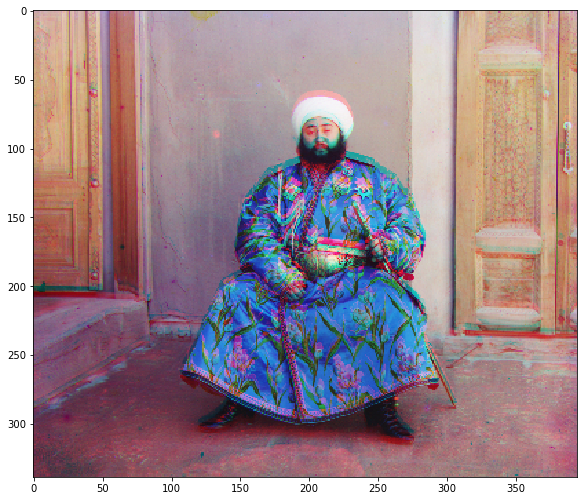

In [144]:
for image in images:
    prep_image = preprocess_image(image)
    print('Aligned')
    align_all(*prep_image, offset=20)

# pyramid

In [19]:
i1 = big_images[0]

In [93]:
prep_image = preprocess_image(i1)

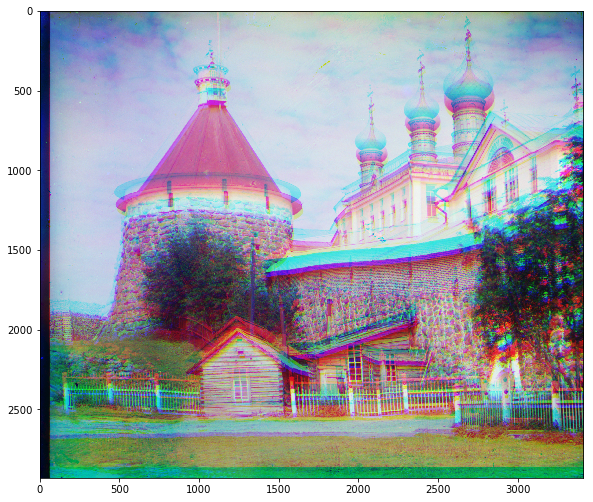

In [95]:
show_channels(*prep_image)

In [133]:
def calc_compress_step(image):
    compress_step = max((image.shape[0] // 500 + 1, image.shape[1] // 500 + 1))
    return compress_step
def compress_image(image, compress_step=None):
    if compress_step is None:
        compress_step = calc_compress_step(image)
    return image[::compress_step, ::compress_step]

In [134]:
red, green, blue = prep_image

In [135]:
compress_step = calc_compress_step(red)
red1, green1, blue1 = (
    compress_image(red, compress_step), 
    compress_image(green, compress_step),
    compress_image(blue, compress_step))

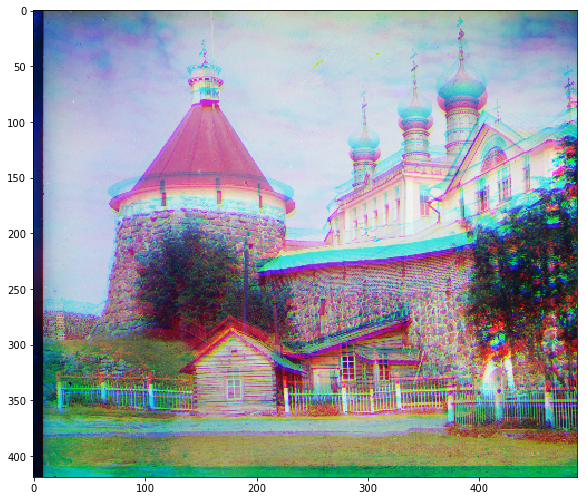

In [136]:
show_channels(red1, green1, blue1)

(35, 22) (24, 21) (20, 20)


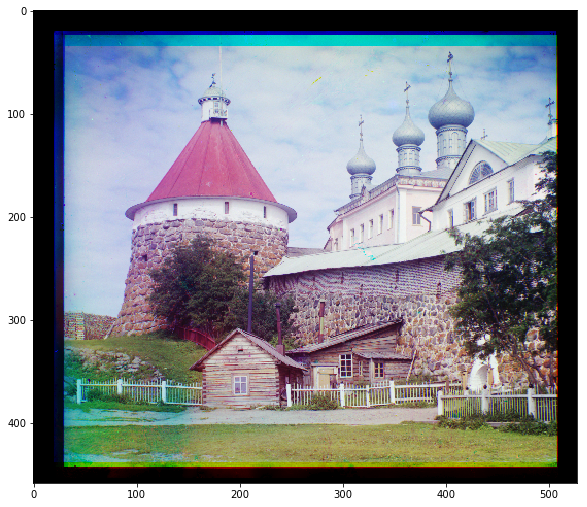

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [120]:
align_all(red1, green1, blue1)